# Libraries

In [1]:
import pandas as pd
import numpy as np
import os as os
import matplotlib.pyplot as plt
import shutup

# Load train data

- iterate through train data folder 
- feature engineer the **country** and **league** from parent folder name
- join the loaded csv files by rows

In [2]:
df = pd.DataFrame()
for root, directory, files in os.walk("data/train", topdown=False):
    if files:
        for file in files:
            tmp = pd.read_csv(f"{root}/{file}")
            # Remove empty rows and columns
            tmp = tmp.dropna(how='all', axis=0)
            tmp = tmp.dropna(how='all', axis=1)
            # Derive additional columns
            tmp["league"] = int(root.split("\\")[2])
            tmp["country"] = root.split("\\")[1]
            tmp["season"] = int(file[:2]) # no. of season - 00/01 - 0th season, 21/22 - 21st season
            df = pd.concat([df, tmp], axis = 0)

df.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,LBAHA,LBAH,LB,LB.1,LB.2,HT,AT,Unnamed: 32,Unnamed: 33,Unnamed: 34
0,B1,20/05/01,Mechelen,Lierse,1.0,1.0,D,1.0,1.0,D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,B1,17/09/00,Germinal,Club Brugge,2.0,3.0,A,0.0,1.0,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,B1,14/10/00,Beveren,Standard,0.0,3.0,A,0.0,2.0,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,B1,06/09/00,Lokeren,Mechelen,3.0,2.0,H,0.0,2.0,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,B1,27/08/00,Charleroi,Antwerp,1.0,0.0,H,1.0,0.0,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Data validation

In some cases, the data is wrong. This section correct the loaded data.

## Same name for different things

In some cases, columns are named differently. We will standardize to use column names that are in *'notes.txt'*


In [3]:
for root, directory, files in os.walk("data/train", topdown=False):
    if files:
        for file in files:
            tmp = pd.read_csv(f"{root}/{file}")
            if "HT" in tmp.columns:
                print(f"Cases for HT: {root}, {file}")
            if "AT" in tmp.columns:
                print(f"Cases for AT: {root}, {file}")

Cases for HT: data/train\greece\1, 0001.csv
Cases for AT: data/train\greece\1, 0001.csv
Cases for HT: data/train\greece\1, 0102.csv
Cases for AT: data/train\greece\1, 0102.csv
Cases for HT: data/train\greece\1, 0203.csv
Cases for AT: data/train\greece\1, 0203.csv
Cases for HT: data/train\greece\1, 0304.csv
Cases for AT: data/train\greece\1, 0304.csv
Cases for HT: data/train\greece\1, 0405.csv
Cases for AT: data/train\greece\1, 0405.csv


The only affected data are in Greece.

In [4]:
df["HomeTeam"] = df["HomeTeam"].mask(df["HT"].notnull(), df["HT"])
df["AwayTeam"] = df["AwayTeam"].mask(df["AT"].notnull(), df["AT"])
df = df.drop(columns = ["HT", "AT"])

## Not imputable data

In some cases, missing data cause the data to be unusable and can't be computed. This applies to variables

- HomeTeam
- AwayTeam

In [5]:
crucial_cols = ['Date', 'HomeTeam', 'AwayTeam']
df = df.dropna(subset = crucial_cols)

In [6]:
df[["HFKC", "AFKC"]].describe()

,HFKC,AFKC
count,1306.000000,1306.000000
mean,16.622511,17.283308
std,4.389023,4.734092
min,2.000000,2.000000
25%,14.000000,14.000000
50%,16.000000,17.000000
75%,19.750000,20.000000
max,32.000000,34.000000


## Goal validation

Some goals are incorrect and they need to be fixed.



In [7]:
goal_cols = ["FTHG", "FTAG", "HTHG", "HTAG"]
df[goal_cols].describe()

,FTHG,FTAG,HTHG,HTAG
count,154586.000000,154563.000000,154536.000000,154543.000000
mean,2.217406,1.131150,0.655342,0.494231
std,21.881446,1.108981,0.809122,0.708230
min,0.000000,-1.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,0.000000
75%,2.000000,2.000000,1.000000,1.000000
max,998.000000,13.000000,7.000000,6.000000


There seems to be several issues:

- the max value for **FTHG** is absurd
- the min value for **FTAG** does not make sense
- some values are missing

In [8]:
df["FTHG"].value_counts().head(12)

FTHG
1.0      51668
2.0      37661
0.0      36033
3.0      18471
4.0       7210
5.0       2346
6.0        752
7.0        185
8.0         42
9.0         14
10.0         5
339.0        5
Name: count, dtype: int64

First, we will remove all rows where the Full Time Home Goals are greater than 10.

In [9]:
df = df[df["FTHG"] <= 10]

Next, all Full Time Away goals that are less than zero are inspected. Since we are not sure which values are good and bad, all of them are removed.

In [10]:
df = df[df["FTAG"] >= 0]

What's left are the missing values. We have no way of recomputing these as well and these rows are again excluded.

In [11]:
df = df[df[goal_cols].isna().sum(axis=1) == 0]

If we run the describe() function again, we can see that the counts are the same and min/max statistics make sense.

In [12]:
df[goal_cols].describe()

,FTHG,FTAG,HTHG,HTAG
count,153901.000000,153901.000000,153901.000000,153901.000000
mean,1.485578,1.133742,0.655395,0.494389
std,1.253277,1.107116,0.809097,0.708477
min,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,0.000000
75%,2.000000,2.000000,1.000000,1.000000
max,10.000000,13.000000,7.000000,6.000000


## Result validation

Another thing that needs to be validated is the result classification, which are re-classified - this is the easiest data validation process.

In [13]:
half_conds = [df["HTHG"] > df["HTAG"], df["HTHG"] < df["HTAG"], df["HTHG"] == df["HTAG"]]
half_choic = ["H"                    , "A"                    , "D"]
df.loc[:, "HTR"] = np.select(half_conds, half_choic)
full_conds = [df["FTHG"] > df["FTAG"], df["FTHG"] < df["FTAG"], df["FTHG"] == df["FTAG"]]
full_choic = ["H"                    , "A"                    , "D"]
df.loc[:, "FTR"] = np.select(full_conds, full_choic)

## Validation of other statistics

First step is to look at simple descriptive statistics.

In [14]:
stat_cols = [
    'Attendance', 'HS', 'AS', 'HST', 'AST', 'HHW', 'AHW',
    'HC', 'AC', 'HF', 'AF', 'HFKC', 'AFKC', 'HO', 'AO', 'HY', 'AY', 'HR', 'AR', "HBP", "ABP"
]

df[stat_cols].describe()

,Attendance,HS,AS,HST,AST,HHW,AHW,HC,AC,HF,...,HFKC,AFKC,HO,AO,HY,AY,HR,AR,HBP,ABP
count,6641.000000,91684.000000,91726.000000,90775.000000,90804.000000,6472.000000,6484.000000,91276.000000,91327.000000,89647.000000,...,1298.000000,1298.000000,6485.000000,6466.000000,91875.000000,91874.000000,91897.000000,91839.00000,6652.000000,6639.000000
mean,12853.621894,12.675352,10.296895,5.231551,4.209748,0.351823,0.260950,5.722841,4.647300,12.849644,...,16.620955,17.298921,3.258288,3.250541,1.642580,1.960413,0.087000,0.11996,15.496843,20.928604
std,13873.200798,4.925163,4.384494,2.808289,2.456644,0.610765,0.543137,2.937912,2.624468,4.556054,...,4.394704,4.740125,2.368060,2.519042,1.293023,1.365235,0.299434,0.35185,14.991016,17.225443
min,123.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,3530.000000,9.000000,7.000000,3.000000,2.000000,0.000000,0.000000,4.000000,3.000000,10.000000,...,14.000000,14.000000,2.000000,1.000000,1.000000,1.000000,0.000000,0.00000,0.000000,10.000000
50%,7014.000000,12.000000,10.000000,5.000000,4.000000,0.000000,0.000000,5.000000,4.000000,12.000000,...,16.000000,17.000000,3.000000,3.000000,1.000000,2.000000,0.000000,0.00000,10.000000,20.000000
75%,17608.000000,16.000000,13.000000,7.000000,6.000000,1.000000,0.000000,7.000000,6.000000,16.000000,...,20.000000,20.000000,5.000000,5.000000,2.000000,3.000000,0.000000,0.00000,20.000000,30.000000
max,69000.000000,46.000000,45.000000,27.000000,23.000000,4.000000,10.000000,26.000000,21.000000,145.000000,...,32.000000,34.000000,16.000000,18.000000,11.000000,10.000000,3.000000,9.00000,115.000000,150.000000


Then we take a look at boxplots for variables where at least one variable falls out of the interval

$$
(\text{q}_{0.25} - 3 * \text{IQR} ; \text{q}_{0.75} + 3 * \text{IQR})
$$

In [15]:
def outliers(x, multi = 3):
    q25 = x.quantile(0.25)
    q75 = x.quantile(0.75)
    iqr = q75 - q25
    outliers = x[(x < q25 - multi * iqr) | (x > q75 + multi * iqr)]
    return len(outliers)

stat_outliers = df[stat_cols].apply(lambda x: outliers(x))
stat_outliers = stat_outliers[stat_outliers != 0]
stat_outliers

Attendance      109
HS               14
AS               23
HST              18
AST               8
AHW            1435
HC              174
AC               73
HF               21
AF               25
HO                4
AO                2
HY              633
AY                2
HR             7548
AR            10254
HBP              13
ABP              24
dtype: int64

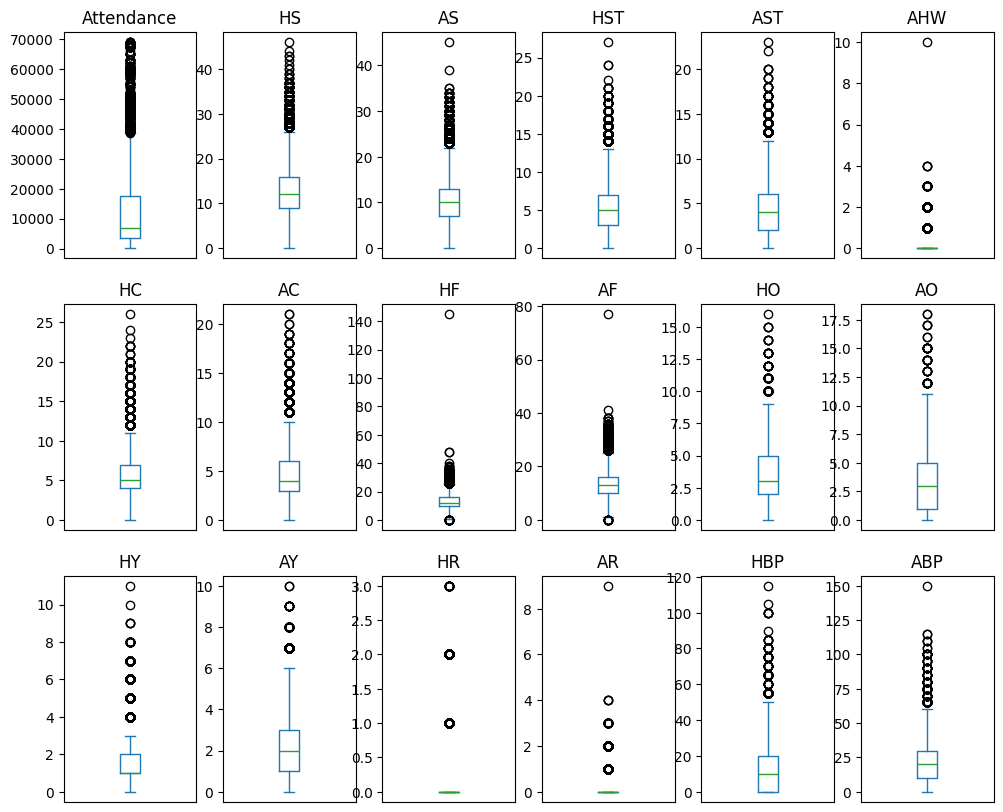

In [16]:
fig, axes = plt.subplots(nrows=3, ncols = 6, figsize = (12, 10))
axes = axes.ravel()

for i, col in enumerate(stat_outliers.index):
    # Data
    df[col].plot(kind='box', ax = axes[i])
    # Styling
    axes[i].set_title(col)
    axes[i].axes.get_xaxis().set_visible(False)

plt.show()


We can se that some outliers are not that extreme. For example variables *HO*, *AO* or *HY* have extreme values, but won't remove them. This is because even tho they can be considered as extreme, there seems to be a natural way how they occured and tehre are no huge jumps between them.

On the other hand, variables *AHW*, *HF*, *AF* and *AR* seem to have some variables that are far away from the other data. Note that we do not consider variables in *HR* as outliers because it looks like it's a discrete variable with mostly zeroes.

In [17]:
stat_jump = [
    "AS", "AHW", "HF", "AF", "AR", "ABP"
]
stats_cut = [
    38, 6, 100, 60, 6, 130
]

print("Number of extreme values:")
for i, col in enumerate(stat_jump):
    cutoff = stats_cut[i]
    x = df[col].to_numpy()
    extreme = x[x > cutoff]
    print(f"{col}: {extreme}, (count: {len(extreme)})")
    
plt.show()

Number of extreme values:
AS: [45. 39.], (count: 2)
AHW: [10.], (count: 1)
HF: [145.], (count: 1)
AF: [77.], (count: 1)
AR: [9.], (count: 1)
ABP: [150.], (count: 1)


Based on the analysis, we see that these extreme values occur at most twice. This is why we chose to remove them.

In [18]:
criteria = dict(zip(stat_jump, stats_cut))
for column, value in criteria.items():
    # .isna() is important because otherwise all na rows are dropped
    df = df[df[column].lt(value) | df[column].isna()]

Finally, we will double-check with boxplots.

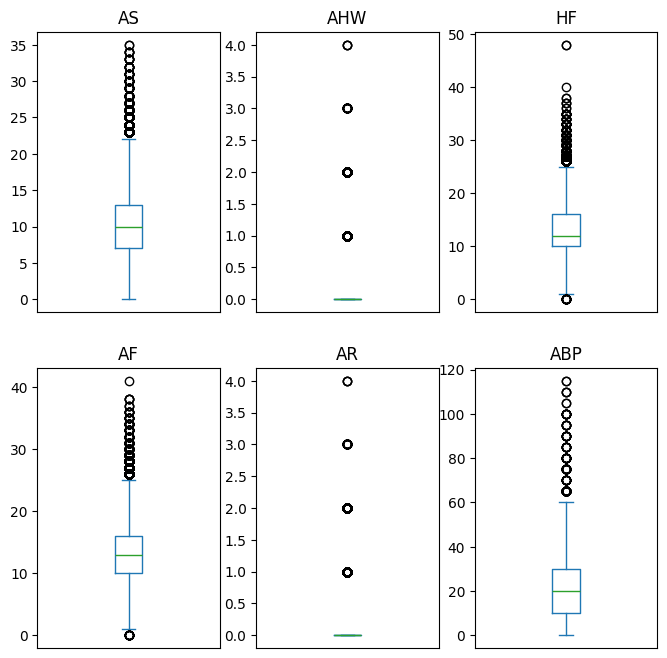

In [19]:
fig, axes = plt.subplots(nrows=2, ncols = 3, figsize = (8, 8))
axes = axes.ravel()

for i, col in enumerate(stat_jump):
    df[col].plot(kind='box', ax = axes[i])
    axes[i].set_title(col)
    axes[i].axes.get_xaxis().set_visible(False)

plt.show()

IT looks like variable *HF* contains another outlier, but this process should be done only once. Hence, no outliers are removed.

## Random unnamed data

File *'data/train/portugal/1/0304.csv'* contains random data in columns *'Unnamed: 33'* and *'Unnamed: 34'*.

In [20]:
unnamed_cols_df = df[['Unnamed: 32', 'Unnamed: 33', 'Unnamed: 34']]
unnamed_cols_df[unnamed_cols_df.notnull().any(axis=1)]

,Unnamed: 32,Unnamed: 33,Unnamed: 34
157,2.0,1.8,-1.75


Since we do not know what these columns represent, and it is only one non-NA row from the whole dataset, this column is removed.

In [21]:
df = df.drop(columns = unnamed_cols_df.columns)

## Wrong betting odds names

File *'data/train/germany/2/0405.csv'* contains columns **LB**, **LB.1** and **LB.2**, which are unique only to this file. After further investigation, they represent the betting odds data for Ladbrokers. After looking at the data more thoroughly, it can be guessed that all three columns represent odds for home win, away win, and draw.

In [22]:
tmp = pd.read_csv("data/train/germany/2/0405.csv")
# Remove empty rows and columns
tmp = tmp.dropna(how='all', axis=0)
tmp = tmp.dropna(how='all', axis=1)
tmp = tmp.loc[:, ~tmp.columns.str.startswith('Unnamed:')]
tmp = tmp[tmp[['LB', 'LB.1', 'LB.2']].notnull().any(axis=1)]
tmp.filter(regex='[HDAB12]$').iloc[:, -12:]

,LB,LB.1,LB.2,SBH,SBD,SBA,WHH,WHD,WHA,GBAHH,GBAHA,GBAH
2,1.67,3.25,NaN,1.62,3.75,5.00,1.65,3.30,4.60,1.65,2.02,-0.50
6,2.00,3.20,NaN,2.10,3.20,3.25,2.15,3.10,3.00,1.77,1.95,-0.25
7,1.91,3.25,NaN,2.00,3.30,3.40,1.90,3.25,3.40,1.95,1.70,-0.50
12,2.60,3.20,2.38,2.70,3.20,2.40,2.50,3.10,2.50,1.43,2.50,0.50
15,2.25,3.20,2.75,2.40,3.00,2.88,2.20,3.10,2.87,2.30,1.48,-0.50
...,...,...,...,...,...,...,...,...,...,...,...,...
291,2.40,3.25,2.50,2.50,3.25,2.50,2.45,3.25,2.45,2.45,1.43,-0.50
294,2.00,3.00,3.40,2.10,3.20,3.25,2.10,3.20,3.00,1.91,1.70,-0.50
295,2.25,3.20,2.75,2.38,3.10,2.88,2.37,3.30,2.50,2.20,1.52,-0.50
297,1.62,3.25,5.00,1.60,3.75,5.00,1.60,3.30,5.00,1.62,2.06,-0.50


Based on column similarity, we can make an edjucated guess that

- **LB** should be **LBH**,
- **LB.1** should be **LBD**, and
- **LB.2** should be **LBA**

In [23]:
# If LB is not null, use that value and replace it in LBH
df["LBH"] = df["LBH"].mask(df["LB"  ].notnull(), df["LB"])
df["LBD"] = df["LBD"].mask(df["LB.1"].notnull(), df["LB.1"])
df["LBA"] = df["LBA"].mask(df["LB.2"].notnull(), df["LB.2"])
df = df.drop(columns = ["LB", "LB.1", "LB.2"])

## Date normalization

Date is not consistent and it needs to be unified in order to format it as date.

In [24]:
potential_fixes = pd.to_datetime(df['Date'], format='mixed', dayfirst=True)
equal = potential_fixes[potential_fixes.isnull()].index.equals(df[df["Date"].isnull()].index)
# if True, all non-na dates have been converted
if equal:
    df["Date"] = potential_fixes
else:
   print("Date indexes are not equal. Something wrong with the conversion??")

## Bookies analysis

In [25]:
#minor warning suppression
shutup.please()

away_odds = df[["B365A", "BSA", "BWA", "GBA", "IWA", "LBA", "PSA", "SOA", "SBA", "SJA", "SYA", "VCA", "WHA"]]
home_odds = df[["B365H", "BSH", "BWH", "GBH", "IWH", "LBH", "PSH", "SOH", "SBH", "SJH", "SYH", "VCH", "WHH"]]
draw_odds = df[["B365D", "BSD", "BWD", "GBD", "IWD", "LBD", "PSD", "SOD", "SBD", "SJD", "SYD", "VCD", "WHD"]]

#Average of away/home/draw odds
df["Avg_away_odds"] = away_odds.mean(axis=1)
df["Avg_home_odds"] = home_odds.mean(axis=1)
df["Avg_draw_odds"] = draw_odds.mean(axis=1)

#Predcition based on averages - Odds with smallest average have the highest probability -> returns A/H/D
df["Avg_bookie_prediction"] = df[["Avg_away_odds", "Avg_home_odds", "Avg_draw_odds"]].idxmin(axis=1).fillna("").astype(str).str[4]
df["Avg_bookie_prediction"] = df["Avg_bookie_prediction"].str.upper()

#Certainity of odds, the smaller variance implies, that bookies are more "sure"
df["Var_away_odds"] = away_odds.var(axis=1)
df["Var_home_odds"] = home_odds.var(axis=1)
df["Var_draw_odds"] = draw_odds.var(axis=1)

print(df.loc[:, "Avg_away_odds":"Var_draw_odds"])

     Avg_away_odds  Avg_home_odds  Avg_draw_odds Avg_bookie_prediction  \
0         2.410000       2.460000       3.250000                     A   
1         1.866667       3.350000       3.300000                     A   
2         1.816667       3.287500       3.362500                     A   
3         4.083333       1.645000       3.450000                     H   
4         4.433333       1.605000       3.387500                     H   
..             ...            ...            ...                   ...   
367       5.373333       1.606667       3.953333                     H   
368       3.426667       2.140000       3.291667                     H   
369       2.005000       3.738333       3.385000                     A   
370       3.140000       2.191667       3.495000                     H   
371       7.143333       1.408333       4.873333                     H   

     Var_away_odds  Var_home_odds  Var_draw_odds  
0         0.007200       0.007200       0.045000  
1        

In [26]:
#Columns for predictions of all bookies
bookies_predictions = pd.DataFrame(columns = ["B365P", "BSP", "BWP", "GBP", "IWP", "LBP", "PSP", "SOP", "SBP", "SJP", "SYP", "VCP", "WHP"])

#dataframe with away/home/draw odds for each bookie
df_bookies_accuracy = pd.concat([away_odds, home_odds, draw_odds, bookies_predictions], axis = 1).sort_index(axis = 1)
df_bookies_accuracy["Outcome"] = df[["FTR"]]

seq = list(range(3, 53, 4))
#"prediction" of each bookie based on their odds
for i in seq:
    df_bookies_accuracy.iloc[:, i] = df_bookies_accuracy.iloc[:, i-3:i].idxmin(axis=1).fillna("").astype(str).str[-1]

print(df_bookies_accuracy)

     B365A  B365D  B365H B365P  BSA  BSD  BSH  BSP   BWA   BWD  ...  SYP  \
0      NaN    NaN    NaN   NaN  NaN  NaN  NaN  NaN   NaN   NaN  ...  NaN   
1      NaN    NaN    NaN   NaN  NaN  NaN  NaN  NaN   NaN   NaN  ...  NaN   
2      NaN    NaN    NaN   NaN  NaN  NaN  NaN  NaN   NaN   NaN  ...  NaN   
3      NaN    NaN    NaN   NaN  NaN  NaN  NaN  NaN   NaN   NaN  ...  NaN   
4      NaN    NaN    NaN   NaN  NaN  NaN  NaN  NaN   NaN   NaN  ...  NaN   
..     ...    ...    ...   ...  ...  ...  ...  ...   ...   ...  ...  ...   
367   4.75   4.00   1.57     H  NaN  NaN  NaN  NaN  5.25  3.90  ...  NaN   
368   3.10   3.50   2.05     H  NaN  NaN  NaN  NaN  3.40  3.25  ...  NaN   
369   1.95   3.30   3.60     A  NaN  NaN  NaN  NaN  1.98  3.30  ...  NaN   
370   3.10   3.50   2.20     H  NaN  NaN  NaN  NaN  3.10  3.50  ...  NaN   
371   7.00   4.75   1.40     H  NaN  NaN  NaN  NaN  7.00  5.00  ...  NaN   

      VCA  VCD   VCH  VCP   WHA   WHD   WHH  WHP Outcome  
0     NaN  NaN   NaN  NaN  2

In [27]:
#Accuracy of each bookie - all around 50% - accuracy of a bookie cannot be used as a weight for prediction
for bookie in bookies_predictions:
    filter_df = df_bookies_accuracy[df_bookies_accuracy[bookie].notna()]
    matching_values = (filter_df[bookie] == filter_df['Outcome']).sum()
    total_values = len(filter_df)
    percent= (matching_values/total_values) *100
    print("Percentage of matching values for " + bookie[:-1] + f": {percent:.2f}%")

Percentage of matching values for B365: 49.87%
Percentage of matching values for BS: 49.79%
Percentage of matching values for BW: 49.89%
Percentage of matching values for GB: 49.95%
Percentage of matching values for IW: 49.78%
Percentage of matching values for LB: 49.82%
Percentage of matching values for PS: 49.91%
Percentage of matching values for SO: 49.27%
Percentage of matching values for SB: 49.94%
Percentage of matching values for SJ: 49.77%
Percentage of matching values for SY: 49.94%
Percentage of matching values for VC: 49.99%
Percentage of matching values for WH: 49.90%


- - -

In [28]:
df.shape

(153894, 173)

**Handicap values fix**
Handicaps are written in quarters - divisible by 0.25

In [29]:
handicap_cols = ['GBAH', 'B365AH', 'BbAHh', 'AHh', 'LBAH', 'AHCh']
df[handicap_cols].describe()

,GBAH,B365AH,AHh,LBAH,AHCh
count,11555.00000,6816.000000,20359.000000,5436.000000,20382.000000
mean,-0.36228,-0.361502,-0.247213,-0.350539,-0.240445
std,0.48475,0.528898,0.677834,0.588715,0.701571
min,-2.25000,-2.500000,-3.750000,-2.250000,-4.000000
25%,-0.50000,-0.750000,-0.500000,-0.750000,-0.500000
50%,-0.50000,-0.250000,-0.250000,-0.250000,-0.250000
75%,-0.25000,0.000000,0.000000,0.000000,0.250000
max,2.50000,1.750000,3.000000,9.000000,3.250000


In [30]:
# handicaps are usually counted in quarters (ending with .0, .25, .50, .75)
for col in handicap_cols:
    df = df[(df[col] % 0.25 == 0) | df[col].isna()] # drop rows with numeric value indivisible by 0.25
for i in handicap_cols:
    print(
        "number of invalid rows left: ", # difference between # of all rows and validated rows
        len(df[i]) - len(df[((df[i] % 0.25 == 0) | (df[i].isna()))])
    )

TypeError: not all arguments converted during string formatting

Betting odds validation (betting odds are positive)

In [ ]:
odds_cols = ['GBH', 'GBD', 'GBA', 'IWH', 'IWD', 'IWA', 'SBH', 'SBD', 'SBA', 'WHH', 'WHD', 'WHA', 'B365CH', 'B365CD', 'B365CA', 'BWCH', 'BWCD', 'BWCA', 'IWCH', 'IWCD', 'IWCA', 'WHCH', 'WHCD', 'WHCA', 'VCCH', 'VCCD', 'VCCA', 'MaxCH', 'MaxCD', 'MaxCA', 'AvgCH','AvgCD', 'AvgCA', 'B365C>2.5', 'B365C<2.5', 'PC>2.5', 'PC<2.5', 'MaxC>2.5', 'MaxC<2.5', 'AvgC>2.5', 'AvgC<2.5', 'AHCh', 'B365CAHH', 'B365CAHA', 'PCAHH', 'PCAHA', 'MaxCAHH', 'MaxCAHA', 'AvgCAHH', 'AvgCAHA']
df[odds_cols] = abs(df[odds_cols])
df[odds_cols].describe()

Drop all completely empty columns and rows which there is a lot of, dropped 41 empty columns in total.

In [ ]:
df.dropna(how='all', axis=1, inplace=True)

In [ ]:
df.shape

# Data Exploration

Total overview of all variables.

In [33]:
df.describe()

,Date,FTHG,FTAG,HTHG,HTAG,GBH,GBD,GBA,IWH,IWD,...,LBAHH,LBAHA,LBAH,Avg_away_odds,Avg_home_odds,Avg_draw_odds,Var_away_odds,Var_home_odds,Var_draw_odds,Index
count,153893,153893.000000,153893.000000,153893.000000,153893.000000,87456.000000,87517.000000,87500.000000,149762.000000,149764.000000,...,5448.000000,5448.000000,5436.000000,153339.000000,153338.000000,153338.000000,152557.000000,152556.000000,152556.000000,153893.000000
mean,2011-06-25 10:40:46.660991744,1.485604,1.133632,0.655397,0.494356,2.275679,3.381784,3.951666,2.336064,3.382672,...,1.911193,1.924781,-0.350539,3.996913,2.399125,3.504659,0.297257,0.039700,0.034543,187.893549
min,2000-07-28 00:00:00,0.000000,0.000000,0.000000,0.000000,1.030000,1.250000,1.030000,1.010000,1.500000,...,-2.250000,-0.500000,-2.250000,1.040000,1.010000,1.250000,0.000000,0.000000,0.000000,0.000000
25%,2005-12-31 00:00:00,1.000000,0.000000,0.000000,0.000000,1.730000,3.100000,2.650000,1.750000,3.050000,...,1.840000,1.840000,-0.750000,2.614286,1.755400,3.171429,0.006417,0.001337,0.006111,85.000000
50%,2011-05-14 00:00:00,1.000000,1.000000,0.000000,0.000000,2.100000,3.250000,3.350000,2.100000,3.200000,...,1.920000,1.920000,-0.250000,3.313750,2.125000,3.306667,0.024167,0.003361,0.011295,169.000000
75%,2016-12-10 00:00:00,2.000000,2.000000,1.000000,1.000000,2.450000,3.450000,4.500000,2.500000,3.450000,...,2.000000,2.000000,0.000000,4.456000,2.566667,3.551000,0.087957,0.009048,0.022229,272.000000
max,2022-05-29 00:00:00,10.000000,9.000000,7.000000,6.000000,24.000000,11.000000,34.000000,30.000000,16.000000,...,3.400000,4.000000,9.000000,68.000000,32.333333,19.214286,468.000000,140.333333,42.154762,542.000000
std,NaN,1.253284,1.106654,0.809103,0.708421,1.041026,0.614256,2.197045,1.155773,0.713703,...,0.174244,0.124480,0.588715,2.607193,1.296643,0.800564,3.017378,0.560029,0.249678,126.529119


Percentage of missing values.

In [34]:
na_vals = df.isna().sum()
na_vals = na_vals/df.shape[0]
na_vals.sort_values(ascending = False).head(20)

HFKC          0.991566
AFKC          0.991566
SYD           0.964748
SYH           0.964696
SYA           0.964696
LBAH          0.964677
LBAHH         0.964599
LBAHA         0.964599
AO            0.958003
HHW           0.957964
AHW           0.957886
HO            0.957880
SOH           0.957340
SOD           0.957250
SOA           0.957243
ABP           0.956879
Attendance    0.956866
HBP           0.956795
B365AH        0.955709
GBAHA         0.924941
dtype: float64

In [36]:
df = df.reset_index(drop = True)

# Get first and last occurrences
first_occurrences = df.apply(lambda x: x.first_valid_index())
last_occurrences = df.apply(lambda x: x.last_valid_index())

missing_counts = {}

for column in df.columns:
    # Indexes of the first and last occurrences
    first_idx = df[column].first_valid_index()
    last_idx = df[column].last_valid_index()

    # Select the range between first and last occurrence, count missing values
    missing_count = df[column][first_idx:last_idx].isnull().sum()
    missing_counts[column] = missing_count

result_df = pd.DataFrame({
    'Variable':          df.columns,
    'First Occurrence':  df["Date"].to_numpy()[first_occurrences.values],
    'Last Occurrence':   df["Date"].to_numpy()[last_occurrences.values],
    "Missing within": missing_counts.values()
})

result_df.sort_values(by="Missing within", ascending=False)

,Variable,First Occurrence,Last Occurrence,Missing within
26,SYD,2002-05-05,2001-08-25,142088
25,SYH,2002-05-05,2001-08-25,142080
27,SYA,2002-05-05,2001-08-25,142080
34,GBAHA,2004-04-03,2004-10-24,136272
35,GBAH,2004-04-03,2004-10-24,136269
...,...,...,...,...
4,FTHG,2001-05-20,2022-05-15,0
3,AwayTeam,2001-05-20,2022-05-15,0
2,HomeTeam,2001-05-20,2022-05-15,0
173,Index,2001-05-20,2022-05-15,0


List of the most missing values.

In [37]:
na_vals = df[df["season"] > 18].isna().sum()

na_vals = na_vals/df[df["season"] > 18].shape[0]*100
na_vals

Div              0.000000
Date             0.000000
HomeTeam         0.000000
AwayTeam         0.000000
FTHG             0.000000
                   ...   
Var_away_odds    0.088235
Var_home_odds    0.088235
Var_draw_odds    0.088235
Index            0.000000
MatchTeams       0.000000
Length: 175, dtype: float64

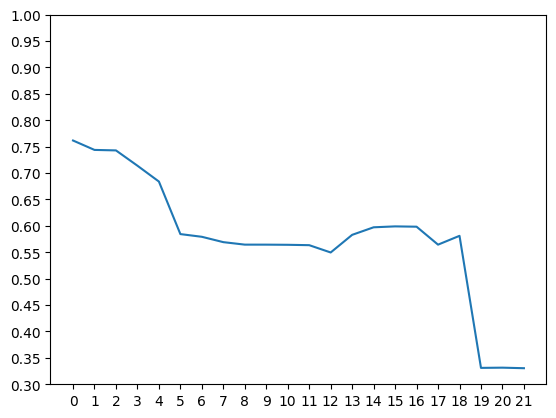

In [38]:
na_vals = [df[df["season"]==i].isna().sum().sum()/(df[df["season"]==i].shape[0]*df[df["season"]==i].shape[1]) for i in range(0,22)]
plt.xticks(range(0,22))
plt.ylim(0.3, 1)
plt.locator_params(axis='y', nbins=14)
plt.plot(na_vals)
plt.gca().ticklabel_format(axis='y', style='plain', scilimits=(0, 0))

# Feature Engineering
We decided to add several features to the dataset.
These features are:
- Result of the last match between the two contending teams
- Goal score during the last match between the two contending teams
- Average amount of goals scored in the current season
- Average amount of goals received in the current season

We believe that these features will prove useful in the training of our model as they can reveal things such as momentum and strenghts/weaknesses against certain teams.

### Result of the last match between the two contending teams

Create a string of participating teams, append them alphabetically behind each other so it is easier to slice them.

In [39]:
df["Index"] = df.index
df["MatchTeams"] = df[["HomeTeam","AwayTeam"]].values.tolist()
df["MatchTeams"] = df["MatchTeams"].sort_values().apply(lambda x: sorted(x))

In [40]:
df = df.assign(MatchTeams=df["MatchTeams"].apply(lambda l: "_".join(l)))

In [41]:
df.sort_values(['MatchTeams','Date'],ascending=True).groupby('MatchTeams').shift()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,LBAHA,LBAH,Avg_away_odds,Avg_home_odds,Avg_draw_odds,Avg_bookie_prediction,Var_away_odds,Var_home_odds,Var_draw_odds,Index
148389,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
148242,T1,2003-11-08,Adanaspor,A. Sebatspor,1.0,2.0,A,0.0,1.0,A,...,NaN,NaN,3.341667,1.881500,3.358333,H,0.044417,0.005085,0.008417,148389.0
148218,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
148237,T1,2003-12-21,Ankaragucu,A. Sebatspor,1.0,1.0,D,1.0,0.0,H,...,NaN,NaN,4.302167,1.644000,3.441667,H,0.028892,0.000972,0.010417,148218.0
148540,T1,2004-05-15,A. Sebatspor,Ankaragucu,3.0,2.0,H,3.0,2.0,H,...,NaN,NaN,6.950000,1.305000,4.507500,H,0.176667,0.000300,0.022892,148237.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39178,E3,2003-09-13,Yeovil,York,3.0,0.0,H,2.0,0.0,H,...,NaN,NaN,3.464286,1.892714,3.235714,H,0.060595,0.000785,0.003929,39392.0
45598,E3,2004-04-20,York,Yeovil,1.0,2.0,A,1.0,0.0,H,...,NaN,NaN,2.200000,2.728333,3.375000,A,0.007000,0.003817,0.015750,39178.0
45653,E3,2015-08-18,York,Yeovil,1.0,0.0,H,0.0,0.0,D,...,NaN,NaN,4.087143,1.934286,3.360000,H,0.168324,0.000462,0.019367,45598.0
147217,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Use groupby to group by same matches, create ["LastMatchIndex","LastMatchAwayGoals", "LastMatchHomeGoals"] columns with unsorted values.
First match of two teams gets empty column index as LastMatchIndex

In [43]:
df[["LastMatchIndex","LastMatchAwayGoals", "LastMatchHomeGoals"]] = df.sort_values(['MatchTeams','Date'],ascending=True).groupby('MatchTeams').shift()[["Index","FTAG", "FTHG"]]
df.loc[np.isnan(df["LastMatchIndex"]), "LastMatchIndex"] = len(df.index)-1
df.loc[len(df.index)] = [np.nan for _ in range(df.shape[1])]
df.loc[len(df.index)-1]
df["LastMatchIndex"] = df["LastMatchIndex"].replace(np.nan, len(df.index)-1)

df["LastMatchIndex"].fillna(len(df.index)-1)
arr = df["LastMatchIndex"]

Switch LastMatchHomeGoals and LastMatchAwayGoals if they do not correspond to the teams accordingly, calculate who won the match

In [44]:
df["SameHomeTeam"] = (df.iloc[arr]["HomeTeam"].values == df["HomeTeam"].values)
df.loc[df["SameHomeTeam"],['LastMatchHomeGoals','LastMatchAwayGoals']] = df.loc[df["SameHomeTeam"],['LastMatchHomeGoals','LastMatchAwayGoals']].values
df["LastMatchAwayWin"] = (df["LastMatchAwayGoals"] > df["LastMatchHomeGoals"]).astype(int)
df["LastMatchHomeWin"] = (df["LastMatchAwayGoals"] < df["LastMatchHomeGoals"]).astype(int)
df["LastMatchDraw"] = (df["LastMatchAwayGoals"] == df["LastMatchHomeGoals"]).astype(int)

In [45]:
df.drop(["SameHomeTeam", "LastMatchIndex", "Index"], axis=1)

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,Avg_bookie_prediction,Var_away_odds,Var_home_odds,Var_draw_odds,MatchTeams,LastMatchAwayGoals,LastMatchHomeGoals,LastMatchAwayWin,LastMatchHomeWin,LastMatchDraw
0,B1,2001-05-20,Mechelen,Lierse,1.0,1.0,D,1.0,1.0,D,...,A,0.007200,0.007200,0.045000,Lierse_Mechelen,1.0,1.0,0,0,1
1,B1,2000-09-17,Germinal,Club Brugge,2.0,3.0,A,0.0,1.0,A,...,A,0.005833,0.056667,0.026667,Club Brugge_Germinal,NaN,NaN,0,0,0
2,B1,2000-10-14,Beveren,Standard,0.0,3.0,A,0.0,2.0,A,...,A,0.003333,0.007292,0.012292,Beveren_Standard,NaN,NaN,0,0,0
3,B1,2000-09-06,Lokeren,Mechelen,3.0,2.0,H,0.0,2.0,A,...,H,0.135833,0.004300,0.010000,Lokeren_Mechelen,NaN,NaN,0,0,0
4,B1,2000-08-27,Charleroi,Antwerp,1.0,0.0,H,1.0,0.0,H,...,H,0.163333,0.000100,0.007292,Antwerp_Charleroi,NaN,NaN,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153890,T1,2022-04-16,Altay,Buyuksehyr,1.0,1.0,D,0.0,1.0,A,...,A,0.001550,0.016417,0.014550,Altay_Buyuksehyr,0.0,0.0,0,0,1
153891,T1,2021-12-19,Fenerbahce,Besiktas,2.0,2.0,D,2.0,1.0,H,...,H,0.005880,0.003417,0.009750,Besiktas_Fenerbahce,1.0,1.0,0,0,1
153892,T1,2022-05-15,Trabzonspor,Altay,2.0,1.0,H,1.0,0.0,H,...,H,0.190267,0.000297,0.042467,Altay_Trabzonspor,2.0,1.0,1,0,0
153893,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0


In [46]:
df[df["MatchTeams"] == "Chelsea_Liverpool"][["Date","FTHG", "FTAG", "LastMatchHomeGoals", "LastMatchAwayGoals", "LastMatchHomeWin","LastMatchAwayWin", "LastMatchDraw"]]

,Date,FTHG,FTAG,LastMatchHomeGoals,LastMatchAwayGoals,LastMatchHomeWin,LastMatchAwayWin,LastMatchDraw
5963,2001-05-08,2.0,2.0,NaN,NaN,0,0,0
6404,2001-12-16,4.0,0.0,2.0,2.0,0,0,1
6453,2002-03-24,1.0,0.0,4.0,0.0,1,0,0
6716,2003-05-11,2.0,1.0,1.0,0.0,1,0,0
6771,2002-10-06,1.0,0.0,1.0,0.0,1,0,0
7126,2003-08-17,1.0,2.0,2.0,1.0,1,0,0
7215,2004-01-07,0.0,1.0,1.0,2.0,0,1,0
7479,2004-10-03,1.0,0.0,0.0,1.0,0,1,0
7560,2005-01-01,0.0,1.0,1.0,0.0,1,0,0
7712,2006-02-05,2.0,0.0,1.0,4.0,0,1,0


# TODO Average amount of goals scored/received in the current season

We will add 4 columns - HomeTeamAvgScored, AwayTeamAvgScored, HomeTeamAvgReceived, AwayTeamAvgReceived



# Export Dataset as .csv file

In [ ]:
df.to_csv("final.csv")